In [18]:
# 1. Imports and Setup
# 
# Multi-series forecasting pipeline for M5 Walmart data with:
# - LOCAL models: Holt-Winters, AutoARIMA, Prophet (train per series)
# - GLOBAL models: TiDE, N-BEATS, TFT (train on all series)
# - Foundation models: Chronos (Amazon), TimeGPT (Nixtla)
#
# Multi-series specifics:
# - Future covariates: wday, month (calendar features)
# - Past covariates: SNAP flags (historical only)
# - Static covariates: unique_id (for DL embeddings)
#
# Metrics: RMSE (primary), MAE (secondary - suitable for count data with zeros)

import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import time
import random
import warnings
import logging
from itertools import product
from tqdm import tqdm

# Suppress all warnings and logging before imports
warnings.filterwarnings("ignore")
os.environ['CMDSTAN_VERBOSE'] = 'FALSE'

# Darts - Time Series Library
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler, StaticCovariatesTransformer
from darts.metrics import rmse, mae
from darts.utils.utils import ModelMode
from darts.models import (
    ExponentialSmoothing,
    AutoARIMA,
    Prophet,
    TiDEModel,
    NBEATSModel,
    TFTModel
)
from sklearn.preprocessing import LabelEncoder

# Foundation Models (optional dependencies)
try:
    from chronos import ChronosPipeline
    import torch
    CHRONOS_AVAILABLE = True
except ImportError:
    CHRONOS_AVAILABLE = False

try:
    from nixtla import NixtlaClient
    TIMEGPT_AVAILABLE = True
except ImportError:
    TIMEGPT_AVAILABLE = False

# Load API keys from external file (not tracked by git)
sys.path.insert(0, '..')
try:
    from api_keys import NIXTLA_API_KEY
except ImportError:
    NIXTLA_API_KEY = None

# Suppress all loggers
for logger_name in ["darts", "prophet", "cmdstanpy", "pytorch_lightning", "nixtla", "httpx"]:
    logging.getLogger(logger_name).setLevel(logging.CRITICAL)

print(f"Chronos: {'Available' if CHRONOS_AVAILABLE else 'Not installed'}")
print(f"TimeGPT: {'Available' if TIMEGPT_AVAILABLE else 'Not installed'}")

Chronos: Available
TimeGPT: Available


Dataset: M5 Walmart Hobbies Daily (5 Series) [SMOKE TEST]
Series: 5 | Train: 172 | Test: 28
Train: 2015-10-08 to 2016-03-27
Test: 2016-03-28 to 2016-04-24


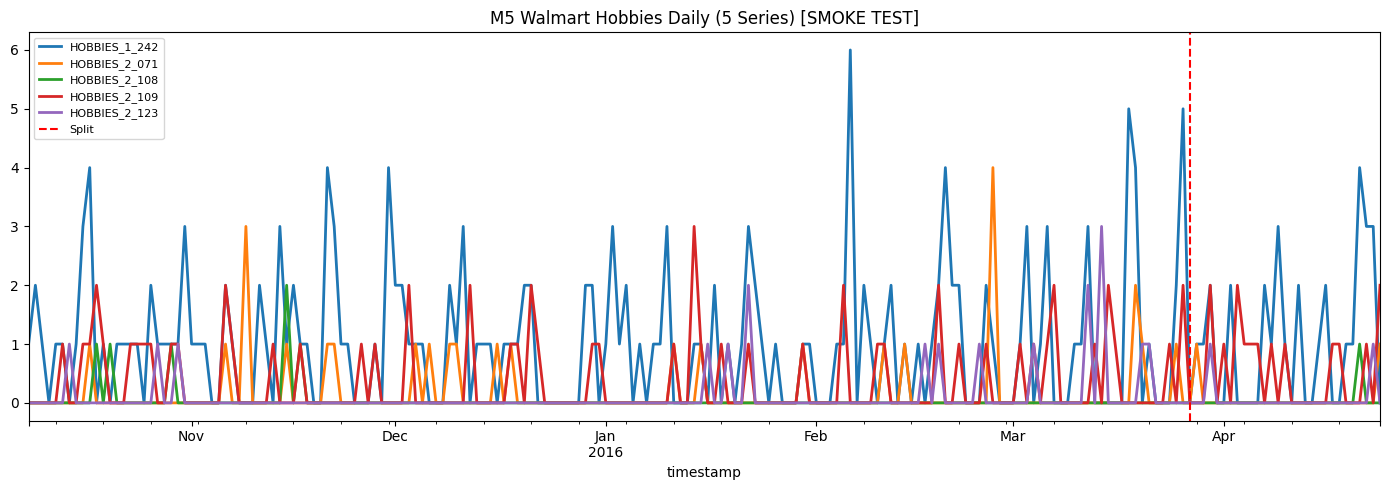

In [19]:
# 2. Data Loading and Configuration (Multi-Series with Covariates)
#
# M5 Walmart dataset: 5 product time series with covariates
# - Future covariates (known ahead): wday, month
# - Past covariates (historical only): SNAP flags
# - Static covariates (per series): unique_id for embeddings

DATASET_CONFIG = {
    'file_path': '../datasets/m5_walmart_hobbies_daily.csv',
    'time_column': 'timestamp',
    'target_column': 'sales_count',
    'id_column': 'unique_id',
    'future_covariates': ['wday', 'month'],
    'past_covariates': ['snap_CA', 'snap_TX', 'snap_WI'],
    'static_covariates': ['unique_id'],
    'frequency': 'D',
    'test_periods': 28,
    'seasonal_period': 7,
    'name': 'M5 Walmart Hobbies Daily (5 Series)'
}

# === SMOKE TEST MODE ===
SMOKE_TEST = True
SMOKE_TEST_POINTS = 200

# === LOAD DATA ===
df = pd.read_csv(DATASET_CONFIG['file_path'])
df[DATASET_CONFIG['time_column']] = pd.to_datetime(df[DATASET_CONFIG['time_column']])

# Encode static covariates for DL embeddings
static_encoder = LabelEncoder()
df['unique_id_encoded'] = static_encoder.fit_transform(df[DATASET_CONFIG['id_column']])

# === CREATE MULTI-SERIES LIST ===
all_series, all_future_covs, all_past_covs = [], [], []

for uid in df[DATASET_CONFIG['id_column']].unique():
    df_uid = df[df[DATASET_CONFIG['id_column']] == uid].sort_values(DATASET_CONFIG['time_column'])
    
    ts = TimeSeries.from_dataframe(
        df_uid, DATASET_CONFIG['time_column'], DATASET_CONFIG['target_column'],
        freq=DATASET_CONFIG['frequency']
    ).astype(np.float32)
    
    static_covs = pd.DataFrame({
        'unique_id': [uid],
        'unique_id_encoded': [df_uid['unique_id_encoded'].iloc[0]]
    })
    ts = ts.with_static_covariates(static_covs)
    all_series.append(ts)
    
    if DATASET_CONFIG['future_covariates']:
        future_cov = TimeSeries.from_dataframe(
            df_uid, DATASET_CONFIG['time_column'], DATASET_CONFIG['future_covariates'],
            freq=DATASET_CONFIG['frequency']
        ).astype(np.float32)
        all_future_covs.append(future_cov)
    
    if DATASET_CONFIG['past_covariates']:
        past_cov = TimeSeries.from_dataframe(
            df_uid, DATASET_CONFIG['time_column'], DATASET_CONFIG['past_covariates'],
            freq=DATASET_CONFIG['frequency']
        ).astype(np.float32)
        all_past_covs.append(past_cov)

# === SMOKE TEST: Use smaller subset ===
if SMOKE_TEST:
    all_series = [s[-SMOKE_TEST_POINTS:] for s in all_series]
    if all_future_covs:
        all_future_covs = [c[-SMOKE_TEST_POINTS:] for c in all_future_covs]
    if all_past_covs:
        all_past_covs = [c[-SMOKE_TEST_POINTS:] for c in all_past_covs]

# === TRAIN/TEST SPLIT (BEFORE scaling) ===
test_periods = DATASET_CONFIG['test_periods']
offset = pd.DateOffset(days=test_periods)
split_time = pd.Timestamp(all_series[0].end_time()) - offset

train_series = [s.split_after(split_time)[0] for s in all_series]
test_series = [s.split_after(split_time)[1] for s in all_series]

if all_future_covs:
    train_future_covs = [c.split_after(split_time)[0] for c in all_future_covs]
else:
    train_future_covs, all_future_covs = None, None

if all_past_covs:
    train_past_covs = [c.split_after(split_time)[0] for c in all_past_covs]
else:
    train_past_covs, all_past_covs = None, None

# === SCALING (fit ONLY on TRAIN data - prevent data leakage) ===
target_scaler = Scaler()
train_scaled = target_scaler.fit_transform(train_series)

if train_future_covs:
    future_cov_scaler = Scaler()
    train_future_covs_scaled = future_cov_scaler.fit_transform(train_future_covs)
    all_future_covs_scaled = future_cov_scaler.transform(all_future_covs)
else:
    train_future_covs_scaled, all_future_covs_scaled = None, None

if train_past_covs:
    past_cov_scaler = Scaler()
    train_past_covs_scaled = past_cov_scaler.fit_transform(train_past_covs)
    all_past_covs_scaled = past_cov_scaler.transform(all_past_covs)
else:
    train_past_covs_scaled, all_past_covs_scaled = None, None

# Static covariates transformer for DL embeddings
static_cov_transformer = StaticCovariatesTransformer()
train_scaled = static_cov_transformer.fit_transform(train_scaled)

print(f"Dataset: {DATASET_CONFIG['name']}" + (" [SMOKE TEST]" if SMOKE_TEST else ""))
print(f"Series: {len(all_series)} | Train: {len(train_series[0])} | Test: {len(test_series[0])}")
print(f"Train: {train_series[0].start_time().date()} to {train_series[0].end_time().date()}")
print(f"Test: {test_series[0].start_time().date()} to {test_series[0].end_time().date()}")

fig, ax = plt.subplots(figsize=(14, 5))
for i, s in enumerate(all_series):
    s.plot(ax=ax, label=f'{s.static_covariates["unique_id"].values[0]}')
ax.axvline(x=split_time, color='red', linestyle='--', label='Split')
ax.set_title(f'{DATASET_CONFIG["name"]}' + (' [SMOKE TEST]' if SMOKE_TEST else ''))
ax.legend(loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()

In [20]:
# 3. Evaluation Metrics and Result Logging
#
# Metrics:
# - RMSE: Primary metric (penalizes large errors)
# - MAE: Mean Absolute Error (secondary, suitable for count data with zeros)

results = []

def log_result(model_name, rmse_val, mae_val, tuning_time, best_config_time, params=None, n_combinations=1):
    """Log model results."""
    results.append({
        'Model': model_name, 'RMSE': rmse_val, 'MAE': mae_val,
        'Tuning Time (s)': tuning_time, 'Best Config Time (s)': best_config_time,
        'Combinations': n_combinations, 'Params': params
    })
    print(f"{model_name}: RMSE={rmse_val:.4f} | MAE={mae_val:.4f} | Time={tuning_time:.1f}s ({n_combinations} combos)")

def get_results_df():
    """Return results as DataFrame sorted by RMSE."""
    return pd.DataFrame(results).sort_values(by='RMSE')

In [21]:
# 4. Hyperparameter Tuning Strategy (Grid/Random Search) with Cross-Validation
#
# LOCAL vs GLOBAL forecasting:
# - LOCAL: Train separate model per series (Holt-Winters, AutoARIMA, Prophet)
# - GLOBAL: Train single model on all series (TiDE, N-BEATS, TFT)
#
# Covariate support:
# - Holt-Winters: NO covariates
# - AutoARIMA, Prophet: future_covariates
# - TiDE, TFT: all covariates | N-BEATS: NO covariates

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

def grid_search_all(param_grid):
    """Generate all parameter combinations for full grid search."""
    if not param_grid:
        return [{}]
    keys, values = list(param_grid.keys()), list(param_grid.values())
    return [dict(zip(keys, combo)) for combo in product(*values)]

def random_grid_search(param_grid, n_iter=5, seed=RANDOM_SEED):
    """Generate random parameter combinations."""
    rng = random.Random(seed)
    keys = list(param_grid.keys())
    if not keys:
        return [{}]
    combinations = [{key: rng.choice(param_grid[key]) for key in keys} for _ in range(n_iter)]
    seen = set()
    return [d for d in combinations if not (key := frozenset((k, str(v)) for k, v in d.items())) in seen and not seen.add(key)]

def filter_invalid_hw_params(combinations):
    """Filter invalid Holt-Winters params (damped=True requires trend != NONE)."""
    return [p for p in combinations if not (p.get('damped', False) and p.get('trend') == ModelMode.NONE)]

# === LOCAL MODEL EVALUATION ===
def evaluate_local_model(model_cls, params, train_list, future_covs_list=None, 
                         supports_covariates=False, forecast_horizon=7, stride=1):
    """Evaluate LOCAL model: train separately on each series, aggregate metrics."""
    start_time = time.time()
    
    try:
        all_backtest, all_actual = [], []
        
        for i, train_s in enumerate(train_list):
            model = model_cls(**params)
            
            future_cov = None
            if supports_covariates and future_covs_list:
                future_cov = future_covs_list[i]
            
            backtest = model.historical_forecasts(
                series=train_s, future_covariates=future_cov, start=0.7,
                forecast_horizon=forecast_horizon, stride=stride,
                retrain=True, verbose=False, last_points_only=True
            )
            all_backtest.append(backtest)
            all_actual.append(train_s)
        
        avg_rmse = np.mean([rmse(a, b) for a, b in zip(all_actual, all_backtest)])
        avg_mae = np.mean([mae(a, b) for a, b in zip(all_actual, all_backtest)])
        
        return avg_rmse, avg_mae, time.time() - start_time
    except Exception as e:
        return float('inf'), float('inf'), 0

# === GLOBAL MODEL EVALUATION ===
def evaluate_global_model(model_cls, params, train_scaled_list, original_train_list, 
                          scaler, future_covs=None, past_covs=None, forecast_horizon=7, stride=1):
    """Evaluate GLOBAL model: train once on all series, aggregate metrics."""
    start_time = time.time()
    
    try:
        model = model_cls(**params)
        model.fit(series=train_scaled_list, future_covariates=future_covs, 
                  past_covariates=past_covs, verbose=False)
        
        all_backtest, all_actual = [], []
        
        for i, (train_s, orig_train) in enumerate(zip(train_scaled_list, original_train_list)):
            backtest_scaled = model.historical_forecasts(
                series=train_s,
                future_covariates=future_covs[i] if future_covs else None,
                past_covariates=past_covs[i] if past_covs else None,
                start=0.7, forecast_horizon=forecast_horizon, stride=stride,
                retrain=False, verbose=False, last_points_only=True
            )
            backtest = scaler.inverse_transform(backtest_scaled)
            all_backtest.append(backtest)
            all_actual.append(orig_train)
        
        avg_rmse = np.mean([rmse(a, b) for a, b in zip(all_actual, all_backtest)])
        avg_mae = np.mean([mae(a, b) for a, b in zip(all_actual, all_backtest)])
        
        return avg_rmse, avg_mae, time.time() - start_time
    except Exception as e:
        return float('inf'), float('inf'), 0

# === UNIFIED TUNING FUNCTIONS ===
def run_tuning_local(model_name, model_cls, param_grid, train_list, future_covs_list=None, 
                     supports_covariates=False, use_full_grid=True, n_iter=5, filter_hw=False):
    """Run hyperparameter tuning for LOCAL models."""
    tuning_start = time.time()
    combinations = grid_search_all(param_grid) if use_full_grid else random_grid_search(param_grid, n_iter=n_iter)
    if filter_hw:
        combinations = filter_invalid_hw_params(combinations)
    
    best_rmse, best_params, best_mae, best_cfg_time = float('inf'), None, 0, 0
    
    for params in tqdm(combinations, desc=model_name):
        rmse_val, mae_val, cfg_time = evaluate_local_model(
            model_cls, params, train_list, future_covs_list=future_covs_list, 
            supports_covariates=supports_covariates
        )
        if rmse_val < best_rmse:
            best_rmse, best_params, best_mae, best_cfg_time = rmse_val, params, mae_val, cfg_time
    
    if best_params and best_rmse != float('inf'):
        log_result(model_name, best_rmse, best_mae, time.time() - tuning_start, 
                   best_cfg_time, best_params, len(combinations))
    return best_params

def run_tuning_global(model_name, model_cls, param_grid, train_scaled_list, original_train_list, 
                      scaler, future_covs=None, past_covs=None, use_full_grid=False, n_iter=10):
    """Run hyperparameter tuning for GLOBAL models."""
    tuning_start = time.time()
    combinations = grid_search_all(param_grid) if use_full_grid else random_grid_search(param_grid, n_iter=n_iter)
    
    best_rmse, best_params, best_mae, best_cfg_time = float('inf'), None, 0, 0
    
    for params in tqdm(combinations, desc=model_name):
        rmse_val, mae_val, cfg_time = evaluate_global_model(
            model_cls, params, train_scaled_list, original_train_list, scaler,
            future_covs=future_covs, past_covs=past_covs
        )
        if rmse_val < best_rmse:
            best_rmse, best_params, best_mae, best_cfg_time = rmse_val, params, mae_val, cfg_time
    
    if best_params and best_rmse != float('inf'):
        log_result(model_name, best_rmse, best_mae, time.time() - tuning_start,
                   best_cfg_time, best_params, len(combinations))
    return best_params

In [22]:
# 5. Statistical Models (LOCAL Forecasting)
#
# LOCAL: Each model trained separately on each time series
# - Holt-Winters: NO covariates (additive only - multiplicative fails with zeros)
# - AutoARIMA: future_covariates (SARIMAX)
# - Prophet: future_covariates (regressors)

SEASONAL_PERIOD = DATASET_CONFIG['seasonal_period']

# Holt-Winters (only additive modes - multiplicative fails with zeros in sales)
hw_grid = {
    'seasonal_periods': [SEASONAL_PERIOD],
    'trend': [ModelMode.ADDITIVE, ModelMode.NONE],
    'seasonal': [ModelMode.ADDITIVE, ModelMode.NONE],
    'damped': [True, False]
}
run_tuning_local("Holt-Winters (LOCAL)", ExponentialSmoothing, hw_grid, train_series,
                 supports_covariates=False, use_full_grid=True, filter_hw=True)

# AutoARIMA with future covariates
try:
    AutoARIMA()
    arima_grid = {
        'season_length': [SEASONAL_PERIOD],
        'seasonal': [True],
        'max_p': [3], 'max_q': [3], 'max_P': [1], 'max_Q': [1], 'max_D': [1], 'max_order': [6]
    }
    run_tuning_local("AutoARIMA (LOCAL)", AutoARIMA, arima_grid, train_series,
                     future_covs_list=all_future_covs, supports_covariates=True, use_full_grid=True)
except Exception:
    pass

# Prophet with future covariates
try:
    Prophet()
    prophet_grid = {
        'seasonality_mode': ['additive'],
        'changepoint_prior_scale': [0.01, 0.1]
    }
    run_tuning_local("Prophet (LOCAL)", Prophet, prophet_grid, train_series,
                     future_covs_list=all_future_covs, supports_covariates=True, use_full_grid=True)
except Exception:
    pass

Holt-Winters (LOCAL): 100%|██████████| 6/6 [00:15<00:00,  2.57s/it]


Holt-Winters (LOCAL): RMSE=0.6499 | MAE=0.4318 | Time=15.4s (6 combos)


AutoARIMA (LOCAL): 100%|██████████| 1/1 [00:58<00:00, 58.51s/it]


AutoARIMA (LOCAL): RMSE=0.6810 | MAE=0.4351 | Time=58.5s (1 combos)


Prophet (LOCAL): 100%|██████████| 2/2 [00:44<00:00, 22.47s/it]

Prophet (LOCAL): RMSE=0.6565 | MAE=0.4348 | Time=44.9s (2 combos)


In [23]:
# 6. Deep Learning Models (GLOBAL Forecasting)
#
# GLOBAL: Single model trained on all series simultaneously
# - TiDE, TFT: All covariates (future + past + static)
# - N-BEATS: NO covariates

base_chunk = SEASONAL_PERIOD
common_dl_params = {
    'input_chunk_length': [base_chunk, base_chunk * 2],
    'output_chunk_length': [1, base_chunk // 2 if base_chunk > 2 else 1, base_chunk],
    'n_epochs': [10, 20],
    'random_state': [RANDOM_SEED],
    'use_static_covariates': [True]
}

# TiDE (Time-series Dense Encoder) - supports all covariates
tide_grid = {**common_dl_params, 'hidden_size': [64, 128], 'dropout': [0.1, 0.2],
             'num_encoder_layers': [1, 2], 'num_decoder_layers': [1, 2]}
run_tuning_global("TiDE (GLOBAL)", TiDEModel, tide_grid, train_scaled, train_series, 
                  target_scaler, future_covs=train_future_covs_scaled, past_covs=train_past_covs_scaled, n_iter=10)

# N-BEATS - NO covariates
nbeats_grid = {
    'input_chunk_length': [base_chunk, base_chunk * 2],
    'output_chunk_length': [1, base_chunk // 2 if base_chunk > 2 else 1, base_chunk],
    'n_epochs': [10, 20], 'random_state': [RANDOM_SEED],
    'num_stacks': [10, 20], 'num_blocks': [1, 2], 'layer_widths': [128, 256]
}
run_tuning_global("N-BEATS (GLOBAL)", NBEATSModel, nbeats_grid, train_scaled, train_series, 
                  target_scaler, future_covs=None, past_covs=None, n_iter=10)

# TFT (Temporal Fusion Transformer) - supports all covariates
tft_grid = {**common_dl_params, 'hidden_size': [16, 32], 'lstm_layers': [1],
            'num_attention_heads': [4], 'dropout': [0.1], 'add_relative_index': [True]}
run_tuning_global("TFT (GLOBAL)", TFTModel, tft_grid, train_scaled, train_series, 
                  target_scaler, future_covs=train_future_covs_scaled, past_covs=train_past_covs_scaled, n_iter=10)

TiDE (GLOBAL): 100%|██████████| 10/10 [00:25<00:00,  2.57s/it]


TiDE (GLOBAL): RMSE=0.4360 | MAE=0.3291 | Time=25.7s (10 combos)


N-BEATS (GLOBAL): 100%|██████████| 9/9 [01:44<00:00, 11.66s/it]


N-BEATS (GLOBAL): RMSE=0.5385 | MAE=0.3942 | Time=105.0s (9 combos)


TFT (GLOBAL): 100%|██████████| 9/9 [02:05<00:00, 13.98s/it]

TFT (GLOBAL): RMSE=1.0587 | MAE=0.6197 | Time=125.8s (9 combos)


{'input_chunk_length': 14,
 'output_chunk_length': 3,
 'n_epochs': 20,
 'random_state': 42,
 'use_static_covariates': True,
 'hidden_size': 16,
 'lstm_layers': 1,
 'num_attention_heads': 4,
 'dropout': 0.1,
 'add_relative_index': True}

In [24]:
# 7. Foundation Models (Chronos, TimeGPT)
#
# Pre-trained models evaluated on TEST set (zero-shot forecasting)
# Work on UNSCALED data (internal normalization)

chronos_pipeline = None

# Chronos (Amazon) - Local, pre-trained transformer
if CHRONOS_AVAILABLE:
    try:
        start_time = time.time()
        chronos_pipeline = ChronosPipeline.from_pretrained(
            "amazon/chronos-t5-small",
            device_map="mps" if torch.backends.mps.is_available() else "cpu",
            dtype=torch.float32
        )
        
        all_pred, all_actual = [], []
        for train_s, test_s in zip(train_series, test_series):
            context = torch.tensor(train_s.values().flatten())
            forecast = chronos_pipeline.predict(context, prediction_length=len(test_s), num_samples=20)
            pred_values = forecast.median(dim=1).values.numpy().flatten()[:len(test_s)]
            pred_ts = TimeSeries.from_times_and_values(times=test_s.time_index, values=pred_values)
            all_pred.append(pred_ts)
            all_actual.append(test_s)
        
        chronos_time = time.time() - start_time
        avg_rmse = np.mean([rmse(a, p) for a, p in zip(all_actual, all_pred)])
        avg_mae = np.mean([mae(a, p) for a, p in zip(all_actual, all_pred)])
        
        log_result("Chronos (GLOBAL)", avg_rmse, avg_mae, chronos_time, chronos_time, 
                   {'model': 'chronos-t5-small'}, 1)
    except Exception as e:
        print(f"Chronos error: {e}")

# TimeGPT (Nixtla) - API-based
if TIMEGPT_AVAILABLE and NIXTLA_API_KEY:
    try:
        start_time = time.time()
        nixtla_client = NixtlaClient(api_key=NIXTLA_API_KEY)
        
        combined_df = []
        for i, train_s in enumerate(train_series):
            df_s = pd.DataFrame({
                'ds': train_s.time_index,
                'y': train_s.values().flatten()
            })
            df_s['unique_id'] = f'series_{i}'
            combined_df.append(df_s)
        combined_df = pd.concat(combined_df, ignore_index=True)
        
        forecast_df = nixtla_client.forecast(df=combined_df, h=len(test_series[0]), 
                                              model='timegpt-1', freq=DATASET_CONFIG['frequency'])
        
        all_pred, all_actual = [], []
        for i, test_s in enumerate(test_series):
            pred_df = forecast_df[forecast_df['unique_id'] == f'series_{i}']
            pred_ts = TimeSeries.from_times_and_values(times=test_s.time_index, values=pred_df['TimeGPT'].values)
            all_pred.append(pred_ts)
            all_actual.append(test_s)
        
        timegpt_time = time.time() - start_time
        avg_rmse = np.mean([rmse(a, p) for a, p in zip(all_actual, all_pred)])
        avg_mae = np.mean([mae(a, p) for a, p in zip(all_actual, all_pred)])
        
        log_result("TimeGPT (GLOBAL)", avg_rmse, avg_mae, timegpt_time, timegpt_time, 
                   {'model': 'timegpt-1'}, 1)
    except Exception as e:
        print(f"TimeGPT error: {e}")

Chronos (GLOBAL): RMSE=0.5957 | MAE=0.3572 | Time=3.5s (1 combos)
TimeGPT (GLOBAL): RMSE=0.5039 | MAE=0.4021 | Time=1.2s (1 combos)


=== Cross-Validation Results (Training Data) ===
               Model   Type     RMSE      MAE  Tuning Time (s)  Combinations
       TiDE (GLOBAL) GLOBAL 0.435990 0.329125        25.729809            10
    TimeGPT (GLOBAL) GLOBAL 0.503899 0.402079         1.195428             1
    N-BEATS (GLOBAL) GLOBAL 0.538464 0.394241       104.982344             9
    Chronos (GLOBAL) GLOBAL 0.595691 0.357232         3.473257             1
Holt-Winters (LOCAL)  LOCAL 0.649939 0.431763        15.404553             6
     Prophet (LOCAL)  LOCAL 0.656495 0.434849        44.948639             2
   AutoARIMA (LOCAL)  LOCAL 0.680997 0.435077        58.507373             1
        TFT (GLOBAL) GLOBAL 1.058726 0.619732       125.814768             9


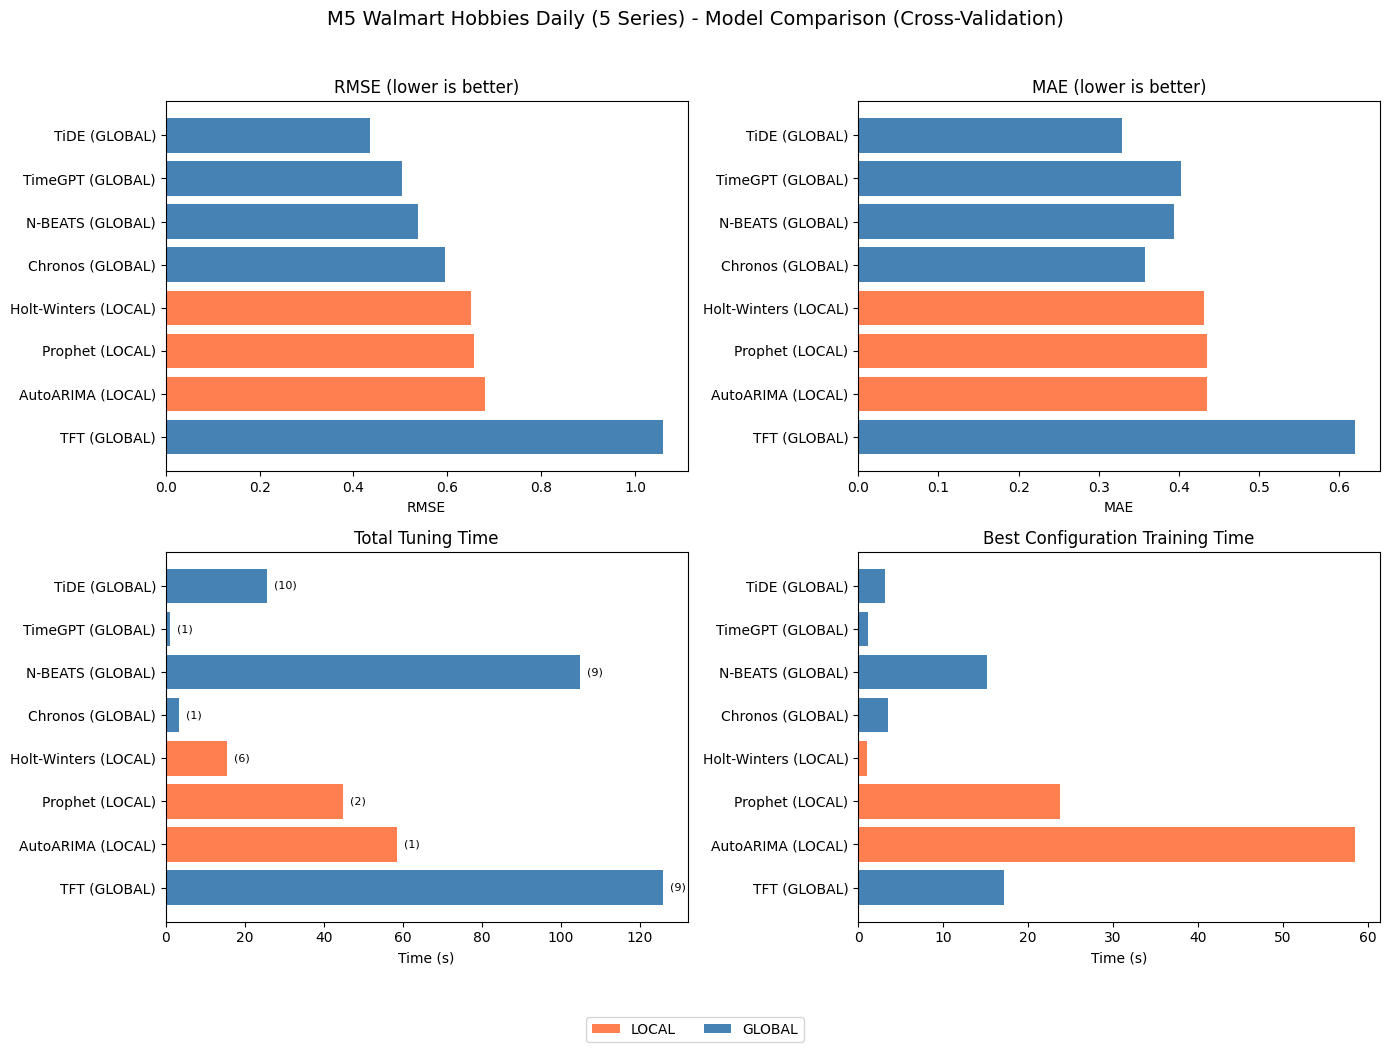


Best RMSE (CV): TiDE (GLOBAL) (0.4360)
Best MAE (CV): TiDE (GLOBAL) (0.3291)
Fastest: TimeGPT (GLOBAL) (1.20s)


In [25]:
# 8. Results Comparison (Cross-Validation Metrics)
#
# These are VALIDATION metrics from cross-validation on training data.
# Final out-of-sample test metrics are computed in Section 9.

results_df = get_results_df()

if results_df.empty:
    print("No results to display.")
else:
    # Add forecasting type column
    results_df['Type'] = results_df['Model'].apply(lambda x: 'GLOBAL' if 'GLOBAL' in x else 'LOCAL')
    
    print("=== Cross-Validation Results (Training Data) ===")
    print(results_df[['Model', 'Type', 'RMSE', 'MAE', 'Tuning Time (s)', 'Combinations']].to_string(index=False))
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    colors = ['coral' if t == 'LOCAL' else 'steelblue' for t in results_df['Type']]
    
    axes[0, 0].barh(results_df['Model'], results_df['RMSE'], color=colors)
    axes[0, 0].set_xlabel('RMSE')
    axes[0, 0].set_title('RMSE (lower is better)')
    axes[0, 0].invert_yaxis()
    
    axes[0, 1].barh(results_df['Model'], results_df['MAE'], color=colors)
    axes[0, 1].set_xlabel('MAE')
    axes[0, 1].set_title('MAE (lower is better)')
    axes[0, 1].invert_yaxis()
    
    axes[1, 0].barh(results_df['Model'], results_df['Tuning Time (s)'], color=colors)
    axes[1, 0].set_xlabel('Time (s)')
    axes[1, 0].set_title('Total Tuning Time')
    axes[1, 0].invert_yaxis()
    for i, (model, combos) in enumerate(zip(results_df['Model'], results_df['Combinations'])):
        axes[1, 0].annotate(f'({combos})', xy=(results_df['Tuning Time (s)'].iloc[i], i),
                            xytext=(5, 0), textcoords='offset points', va='center', fontsize=8)
    
    axes[1, 1].barh(results_df['Model'], results_df['Best Config Time (s)'], color=colors)
    axes[1, 1].set_xlabel('Time (s)')
    axes[1, 1].set_title('Best Configuration Training Time')
    axes[1, 1].invert_yaxis()
    
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='coral', label='LOCAL'), Patch(facecolor='steelblue', label='GLOBAL')]
    fig.legend(handles=legend_elements, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 0.02))
    
    plt.suptitle(f'{DATASET_CONFIG["name"]} - Model Comparison (Cross-Validation)', fontsize=14, y=1.02)
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.show()
    
    print(f"\nBest RMSE (CV): {results_df.iloc[0]['Model']} ({results_df.iloc[0]['RMSE']:.4f})")
    print(f"Best MAE (CV): {results_df.sort_values('MAE').iloc[0]['Model']} ({results_df.sort_values('MAE').iloc[0]['MAE']:.4f})")
    print(f"Fastest: {results_df.sort_values('Tuning Time (s)').iloc[0]['Model']} ({results_df.sort_values('Tuning Time (s)').iloc[0]['Tuning Time (s)']:.2f}s)")

In [26]:
# 9. Final Predictions with Best and Fastest Models
#
# Train best models on FULL training set and generate out-of-sample forecasts.
# Compute TRUE out-of-sample metrics on held-out test set.

def train_and_predict_local(model_name, params, train_list, test_list, future_covs=None):
    """Train LOCAL model on each series and return predictions."""
    model_map = {"Holt-Winters (LOCAL)": ExponentialSmoothing, 
                 "AutoARIMA (LOCAL)": AutoARIMA, "Prophet (LOCAL)": Prophet}
    supports_cov = {"Holt-Winters (LOCAL)": False, "AutoARIMA (LOCAL)": True, "Prophet (LOCAL)": True}
    
    if model_name not in model_map:
        return None
    
    predictions = []
    for i, (train_s, test_s) in enumerate(zip(train_list, test_list)):
        model = model_map[model_name](**params)
        if supports_cov.get(model_name, False) and future_covs:
            model.fit(train_s, future_covariates=future_covs[i])
            pred = model.predict(len(test_s), future_covariates=future_covs[i])
        else:
            model.fit(train_s)
            pred = model.predict(len(test_s))
        predictions.append(pred)
    return predictions

def train_and_predict_global(model_name, params, train_scaled_list, train_list, test_list, 
                             scaler, future_covs_scaled=None, past_covs_scaled=None,
                             all_future_covs_scaled=None, all_past_covs_scaled=None):
    """Train GLOBAL model on all series and return predictions."""
    model_map = {"TiDE (GLOBAL)": TiDEModel, "N-BEATS (GLOBAL)": NBEATSModel, "TFT (GLOBAL)": TFTModel}
    no_cov_models = ["N-BEATS (GLOBAL)"]
    
    if model_name not in model_map:
        return None
    
    model = model_map[model_name](**params)
    uses_cov = model_name not in no_cov_models
    
    model.fit(series=train_scaled_list, 
              future_covariates=future_covs_scaled if uses_cov else None,
              past_covariates=past_covs_scaled if uses_cov else None, verbose=False)
    
    predictions = []
    for i, (train_s, test_s) in enumerate(zip(train_scaled_list, test_list)):
        pred_scaled = model.predict(
            n=len(test_s), series=train_s,
            future_covariates=all_future_covs_scaled[i] if uses_cov and all_future_covs_scaled else None,
            past_covariates=all_past_covs_scaled[i] if uses_cov and all_past_covs_scaled else None
        )
        pred = scaler.inverse_transform(pred_scaled)
        predictions.append(pred)
    return predictions

def train_and_predict_chronos(train_list, test_list):
    """Generate predictions using Chronos."""
    if not CHRONOS_AVAILABLE or chronos_pipeline is None:
        return None
    predictions = []
    for train_s, test_s in zip(train_list, test_list):
        context = torch.tensor(train_s.values().flatten())
        forecast = chronos_pipeline.predict(context, prediction_length=len(test_s), num_samples=20)
        pred_values = forecast.median(dim=1).values.numpy().flatten()[:len(test_s)]
        pred = TimeSeries.from_times_and_values(times=test_s.time_index, values=pred_values)
        predictions.append(pred)
    return predictions

final_predictions = {}

if not results_df.empty:
    best_row = results_df.iloc[0]
    fastest_row = results_df.sort_values('Tuning Time (s)').iloc[0]
    
    print(f"Best RMSE: {best_row['Model']} | RMSE: {best_row['RMSE']:.4f} | MAE: {best_row['MAE']:.4f}")
    print(f"Fastest: {fastest_row['Model']} | RMSE: {fastest_row['RMSE']:.4f} | Time: {fastest_row['Tuning Time (s)']:.1f}s")
    
    # Best model predictions
    if 'LOCAL' in best_row['Model']:
        pred_best = train_and_predict_local(best_row['Model'], best_row['Params'], 
                                            train_series, test_series, all_future_covs)
    elif 'Chronos' in best_row['Model']:
        pred_best = train_and_predict_chronos(train_series, test_series)
    else:
        pred_best = train_and_predict_global(best_row['Model'], best_row['Params'], train_scaled, 
                                             train_series, test_series, target_scaler,
                                             train_future_covs_scaled, train_past_covs_scaled,
                                             all_future_covs_scaled, all_past_covs_scaled)
    
    if pred_best:
        test_rmse = np.mean([rmse(a, p) for a, p in zip(test_series, pred_best)])
        test_mae = np.mean([mae(a, p) for a, p in zip(test_series, pred_best)])
        print(f"\n[OUT-OF-SAMPLE] {best_row['Model']}: RMSE={test_rmse:.4f} | MAE={test_mae:.4f}")
        final_predictions['best_rmse'] = {
            'model': best_row['Model'], 'predictions': pred_best, 'params': best_row['Params'],
            'rmse': test_rmse, 'mae': test_mae,
            'tuning_time': best_row['Tuning Time (s)'], 'combinations': best_row['Combinations']
        }
    
    # Fastest model predictions (if different)
    if fastest_row['Model'] == best_row['Model']:
        final_predictions['fastest'] = final_predictions.get('best_rmse')
    else:
        if 'LOCAL' in fastest_row['Model']:
            pred_fast = train_and_predict_local(fastest_row['Model'], fastest_row['Params'],
                                                train_series, test_series, all_future_covs)
        elif 'Chronos' in fastest_row['Model']:
            pred_fast = train_and_predict_chronos(train_series, test_series)
        else:
            pred_fast = train_and_predict_global(fastest_row['Model'], fastest_row['Params'], train_scaled,
                                                 train_series, test_series, target_scaler,
                                                 train_future_covs_scaled, train_past_covs_scaled,
                                                 all_future_covs_scaled, all_past_covs_scaled)
        
        if pred_fast:
            test_rmse_fast = np.mean([rmse(a, p) for a, p in zip(test_series, pred_fast)])
            test_mae_fast = np.mean([mae(a, p) for a, p in zip(test_series, pred_fast)])
            print(f"[OUT-OF-SAMPLE] {fastest_row['Model']}: RMSE={test_rmse_fast:.4f} | MAE={test_mae_fast:.4f}")
            final_predictions['fastest'] = {
                'model': fastest_row['Model'], 'predictions': pred_fast, 'params': fastest_row['Params'],
                'rmse': test_rmse_fast, 'mae': test_mae_fast,
                'tuning_time': fastest_row['Tuning Time (s)'], 'combinations': fastest_row['Combinations']
            }

Best RMSE: TiDE (GLOBAL) | RMSE: 0.4360 | MAE: 0.3291
Fastest: TimeGPT (GLOBAL) | RMSE: 0.5039 | Time: 1.2s


Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]


[OUT-OF-SAMPLE] TiDE (GLOBAL): RMSE=0.7547 | MAE=0.6031


In [27]:
# 10. Interactive Visualization (Plotly)
#
# Interactive forecast comparison with zoom, pan, and hover capabilities.
# Shows predictions for first series as representative example.

def create_interactive_forecast_plot(train_list, test_list, predictions_dict, dataset_name, 
                                      series_idx=0, target_column=None):
    """Create interactive forecast comparison plot using Plotly."""
    n_plots = len([k for k in ['best_rmse', 'fastest'] if predictions_dict.get(k)])
    if n_plots == 0:
        return None
    
    same_model = predictions_dict.get('best_rmse', {}).get('model') == predictions_dict.get('fastest', {}).get('model')
    if same_model:
        n_plots = 1
    
    train_s = train_list[series_idx]
    test_s = test_list[series_idx]
    series_name = train_s.static_covariates['unique_id'].values[0] if hasattr(train_s, 'static_covariates') else f'Series {series_idx}'
    
    fig = make_subplots(rows=1, cols=n_plots, horizontal_spacing=0.08)
    colors = {'train': '#1f77b4', 'test': '#2ca02c', 'pred1': '#d62728', 'pred2': '#ff7f0e'}
    
    def add_traces(pred_key, col, show_legend=True, show_forecast_legend_only=False):
        if pred_key not in predictions_dict:
            return
        pred_info = predictions_dict[pred_key]
        pred = pred_info['predictions'][series_idx]
        
        fig.add_trace(go.Scatter(
            x=train_s.time_index, y=train_s.values().flatten(),
            mode='lines', name='Train', line=dict(color=colors['train'], width=1.5),
            showlegend=show_legend and not show_forecast_legend_only,
            hovertemplate='<b>Train</b><br>Date: %{x}<br>Value: %{y:.4f}<extra></extra>'
        ), row=1, col=col)
        
        fig.add_trace(go.Scatter(
            x=test_s.time_index, y=test_s.values().flatten(),
            mode='lines', name='Test (Actual)', line=dict(color=colors['test'], width=2),
            showlegend=show_legend and not show_forecast_legend_only,
            hovertemplate='<b>Actual</b><br>Date: %{x}<br>Value: %{y:.4f}<extra></extra>'
        ), row=1, col=col)
        
        pred_color = colors['pred1'] if col == 1 else colors['pred2']
        fig.add_trace(go.Scatter(
            x=pred.time_index, y=pred.values().flatten(),
            mode='lines', name=f'Forecast ({pred_info["model"]})',
            line=dict(color=pred_color, width=2, dash='dash'),
            showlegend=show_legend,
            hovertemplate=f'<b>{pred_info["model"]}</b><br>Date: %{{x}}<br>Pred: %{{y:.4f}}<extra></extra>'
        ), row=1, col=col)
    
    if 'best_rmse' in predictions_dict:
        add_traces('best_rmse', 1, show_legend=True)
    if not same_model and 'fastest' in predictions_dict:
        add_traces('fastest', 2, show_legend=True, show_forecast_legend_only=True)
    
    fig.update_layout(
        title=dict(text=f'<b>{dataset_name}</b> - Out-of-Sample Forecast ({series_name})', font=dict(size=16)),
        width=1700, height=500, hovermode='x unified',
        legend=dict(orientation='h', yanchor='bottom', y=1.08, xanchor='right', x=1),
        xaxis=dict(rangeslider=dict(visible=True, thickness=0.05), type='date', title='Date'),
        yaxis=dict(title=target_column if target_column else 'Value')
    )
    
    if n_plots == 2:
        fig.update_xaxes(rangeslider=dict(visible=True, thickness=0.05), type='date', title='Date', row=1, col=2)
        fig.update_yaxes(title=target_column if target_column else 'Value', row=1, col=2)
    
    annotations = []
    if 'best_rmse' in predictions_dict:
        info = predictions_dict['best_rmse']
        annotations.append(dict(
            x=0.22 if n_plots == 2 else 0.5, y=1.02, xref='paper', yref='paper',
            text=f"<b>Best Model: {info['model']}</b>", showarrow=False, font=dict(size=13), xanchor='center'
        ))
        annotations.append(dict(
            x=0.22 if n_plots == 2 else 0.5, y=-0.18, xref='paper', yref='paper',
            text=f"Test RMSE: {info['rmse']:.4f} | Test MAE: {info['mae']:.4f} | Tuning: {info['tuning_time']:.1f}s",
            showarrow=False, font=dict(size=10), xanchor='center'
        ))
    if not same_model and 'fastest' in predictions_dict:
        info = predictions_dict['fastest']
        annotations.append(dict(
            x=0.78, y=1.02, xref='paper', yref='paper',
            text=f"<b>Fastest Model: {info['model']}</b>", showarrow=False, font=dict(size=13), xanchor='center'
        ))
        annotations.append(dict(
            x=0.78, y=-0.18, xref='paper', yref='paper',
            text=f"Test RMSE: {info['rmse']:.4f} | Test MAE: {info['mae']:.4f} | Tuning: {info['tuning_time']:.1f}s",
            showarrow=False, font=dict(size=10), xanchor='center'
        ))
    
    fig.update_layout(
        annotations=annotations, margin=dict(b=100),
        updatemenus=[dict(
            type="buttons", direction="left", x=0.0, xanchor="left", y=1.15, yanchor="top",
            buttons=[
                dict(args=[{"xaxis.autorange": True, "xaxis2.autorange": True}], label="Reset Zoom", method="relayout"),
                dict(args=[{"xaxis.range": [test_s.start_time(), test_s.end_time()],
                           "xaxis2.range": [test_s.start_time(), test_s.end_time()]}],
                     label="Zoom to Test Period", method="relayout")
            ]
        )]
    )
    return fig

if final_predictions:
    fig = create_interactive_forecast_plot(
        train_series, test_series, final_predictions, DATASET_CONFIG['name'],
        series_idx=0, target_column=DATASET_CONFIG['target_column']
    )
    if fig:
        fig.show()

In [28]:
# 11. All Models Comparison (Interactive)
#
# Summary comparison of all models based on cross-validation metrics.

def create_all_models_comparison(results_dataframe, dataset_name):
    """Create interactive bar chart comparison of all models."""
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=[
            'RMSE (lower is better)',
            'MAE (lower is better)',
            'Total Tuning Time (s)',
            'Best Config Training Time (s)'
        ],
        vertical_spacing=0.15, horizontal_spacing=0.1
    )
    
    models = results_dataframe['Model'].tolist()
    colors = ['coral' if 'LOCAL' in m else 'steelblue' for m in models]
    
    fig.add_trace(go.Bar(
        y=models, x=results_dataframe['RMSE'], orientation='h',
        marker_color=colors,
        hovertemplate='<b>%{y}</b><br>RMSE: %{x:.4f}<extra></extra>'
    ), row=1, col=1)
    
    fig.add_trace(go.Bar(
        y=models, x=results_dataframe['MAE'], orientation='h',
        marker_color=colors,
        hovertemplate='<b>%{y}</b><br>MAE: %{x:.4f}<extra></extra>'
    ), row=1, col=2)
    
    fig.add_trace(go.Bar(
        y=models, x=results_dataframe['Tuning Time (s)'], orientation='h',
        marker_color=colors,
        text=[f"({c})" for c in results_dataframe['Combinations']],
        textposition='outside',
        hovertemplate='<b>%{y}</b><br>Time: %{x:.2f}s<extra></extra>'
    ), row=2, col=1)
    
    fig.add_trace(go.Bar(
        y=models, x=results_dataframe['Best Config Time (s)'], orientation='h',
        marker_color=colors,
        hovertemplate='<b>%{y}</b><br>Time: %{x:.2f}s<extra></extra>'
    ), row=2, col=2)
    
    fig.update_layout(
        title=dict(text=f'<b>{dataset_name}</b> - All Models Comparison (Cross-Validation)', font=dict(size=16)),
        width=1700, height=600, showlegend=False, margin=dict(l=150)
    )
    
    for i in range(1, 3):
        for j in range(1, 3):
            fig.update_yaxes(autorange='reversed', row=i, col=j)
    return fig

if 'results_df' in dir() and not results_df.empty:
    fig_comparison = create_all_models_comparison(results_df, DATASET_CONFIG['name'])
    fig_comparison.show()